In [4]:
import numpy as np
import scipy
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

White nosie:

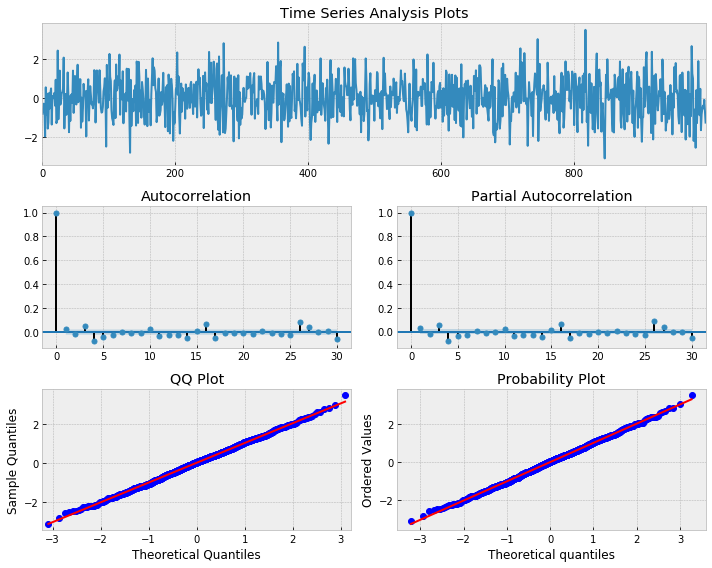

In [12]:
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

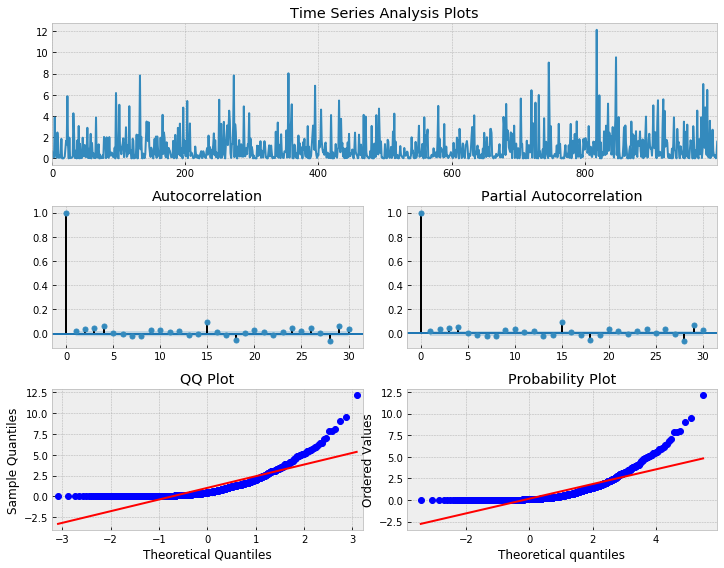

In [13]:
tsplot(np.power(randser,2), lags=30)

Random walk:

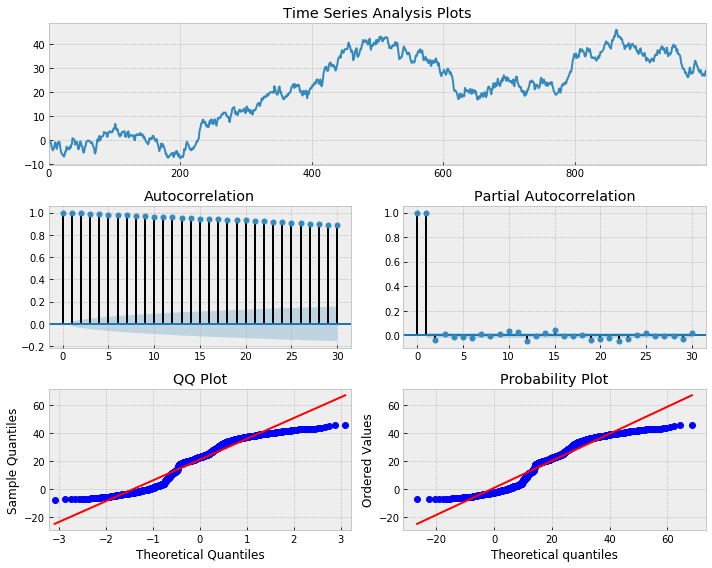

In [17]:
# Random Walk without a drift
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Linear Model: The significance of the PACF at lag 1 indicates that an autoregressive model AR(p) may be appropriate.

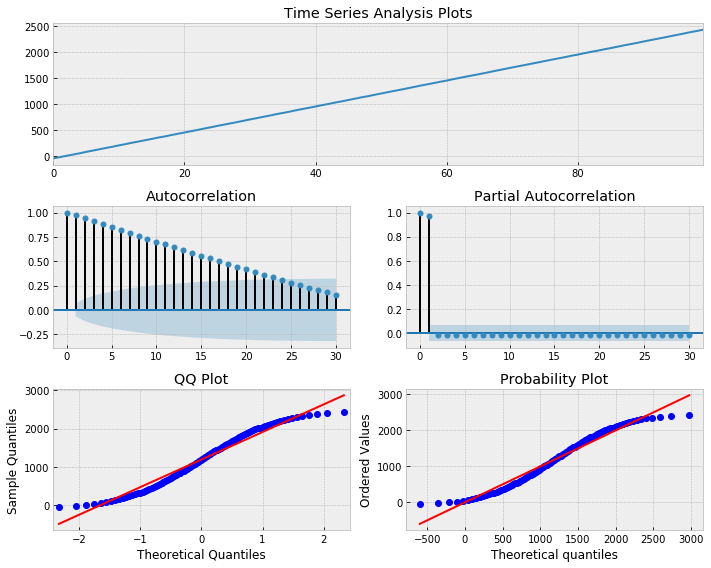

In [18]:
#  simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

Log-linear model:

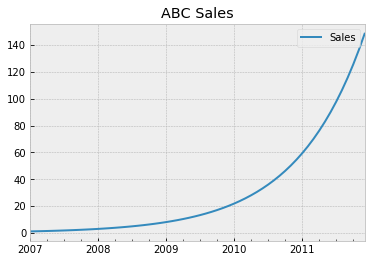

In [19]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

AR(1):

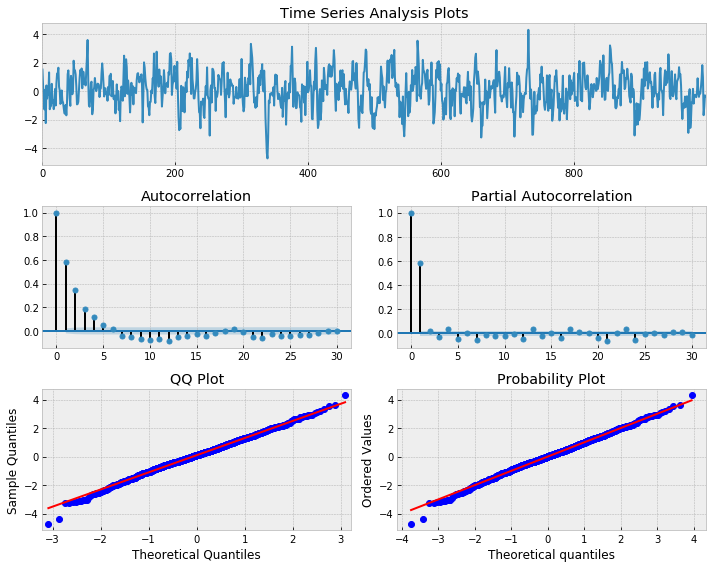

In [20]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

Fit an AR(p) model: Not knowing what p is.

In [21]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'  .format(a, true_order))

Wall time: 11.2 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


AR(2):

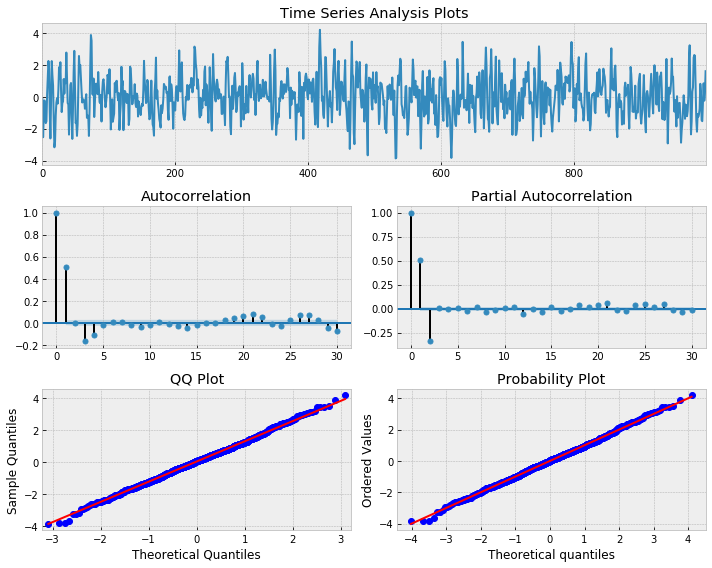

In [22]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

Fit an AR(p) model: Not knowing what p is.

In [23]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(ar2).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(ar2).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))

Wall time: 11.2 s

coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


Example of AR model on real data:

In [24]:
# Select best lag order for MSFT returns
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

best estimated lag order = 23


Plot residuals: ideally we want white noise

Residual is not bad. The model's order (23) is too high.

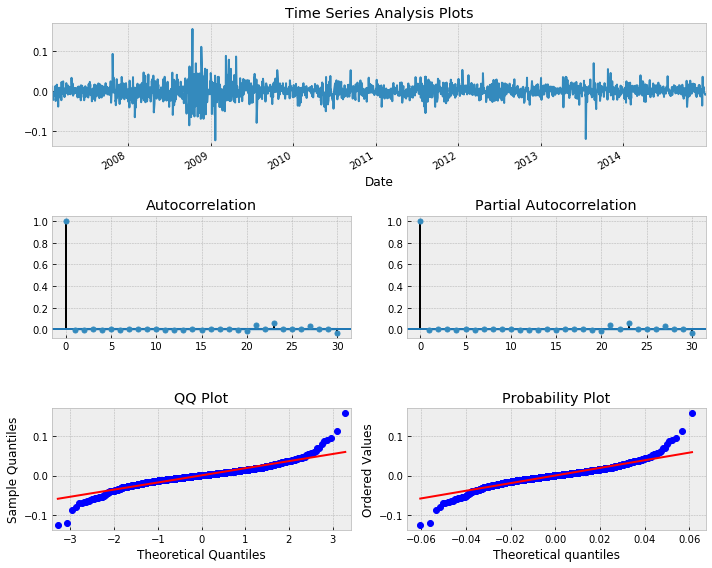

In [25]:
_ = tsplot(mdl.resid, lags=30)

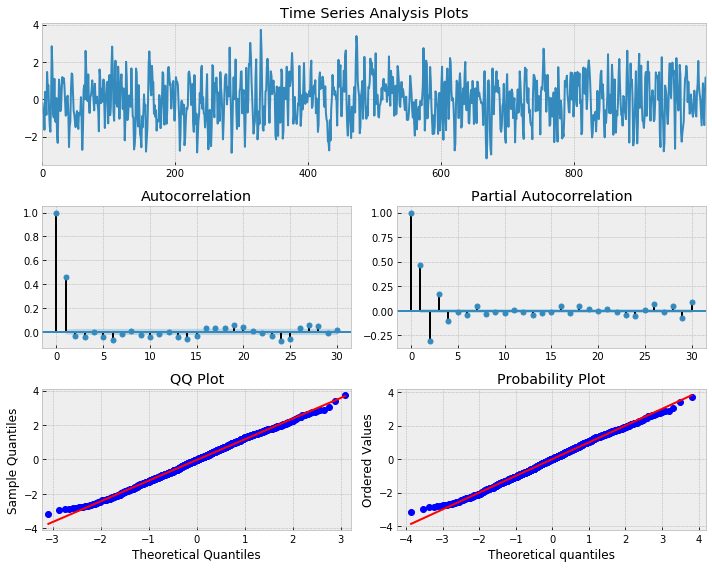

In [156]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [157]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1412.689
Method:                           mle   S.D. of innovations              0.993
Date:                Sun, 14 Jan 2018   AIC                           2829.379
Time:                        16:16:28   BIC                           2839.194
Sample:                             0   HQIC                          2833.109
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6579      0.023     29.063      0.000       0.614       0.702
                                    Roots                                    
                 Real           Imaginary           M

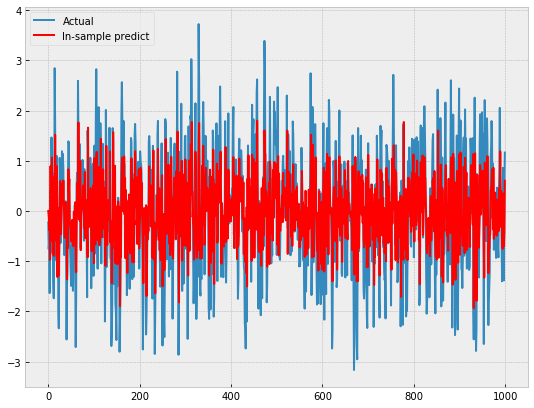

In [182]:
# in sample predict
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = ma1
plt.plot(ts, label='Actual')
# in sample prediction
pred = mdl.predict()
plt.plot(pred, 'r-', label = "In-sample predict")
plt.legend(loc='upper left')

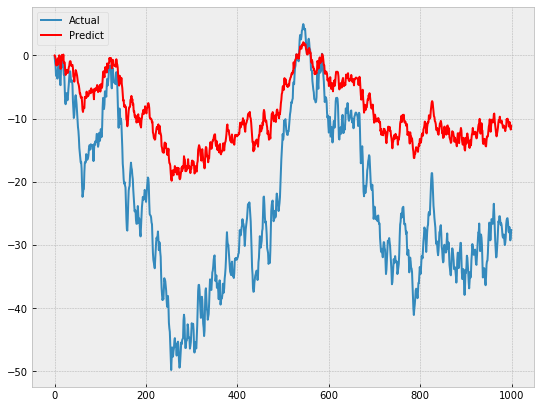

In [184]:
    fig = plt.figure(figsize=(9,7))
    ax = plt.gca()
    plt.plot(ma1.cumsum(), label='Actual')
    plt.plot(pred.cumsum(), 'r-', label='Predict')
    plt.legend(loc='upper left')

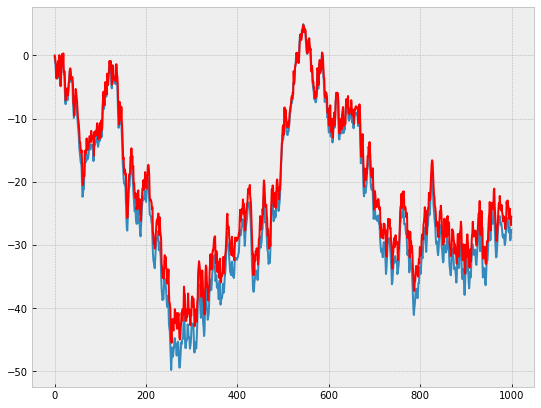

In [179]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = ma1
plt.plot(ts.cumsum(), label='Spy Returns')
# in sample prediction
pred = mdl.predict()
pred = pred*(np.std(ma1))/(np.std(pred))*1.25
plt.plot(pred.cumsum(), 'r-')


Correctly estimate that the 2nd order is 0:

In [28]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 2)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 2)   Log Likelihood               -1389.998
Method:                           mle   S.D. of innovations              0.971
Date:                Sat, 13 Jan 2018   AIC                           2785.996
Time:                        22:02:42   BIC                           2800.719
Sample:                             0   HQIC                          2791.591
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5675      0.032     17.896      0.000       0.505       0.630
ma.L2.y       -0.0311      0.031     -1.015      0.310      -0.091       0.029
                                    Roots           

In [29]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(5, 0)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(5, 0)   Log Likelihood               -1388.348
Method:                           mle   S.D. of innovations              0.970
Date:                Sat, 13 Jan 2018   AIC                           2788.697
Time:                        22:02:42   BIC                           2818.143
Sample:                             0   HQIC                          2799.888
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5680      0.032     18.012      0.000       0.506       0.630
ar.L2.y       -0.3587      0.036     -9.953      0.000      -0.429      -0.288
ar.L3.y        0.2385      0.037      6.443      0.0

Use ARMA on a real return example:

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.953
Method:                           mle   S.D. of innovations              0.014
Date:                Sat, 13 Jan 2018   AIC                         -11505.906
Time:                        22:02:43   BIC                         -11483.476
Sample:                    01-04-2007   HQIC                        -11497.673
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

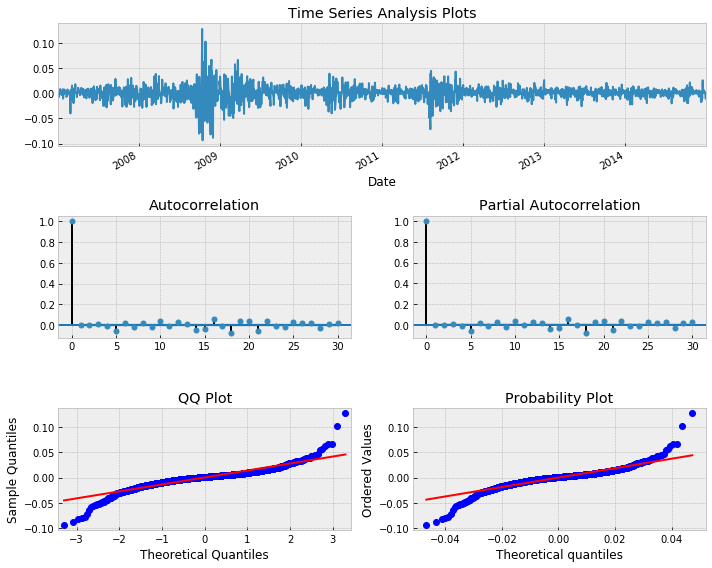

In [30]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

Residual is not bad. Some heavy tail on it though.

ARMA(p,q)
- AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 
- MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

ARMA's weakness is that it ignores the volatility clustering effects found in most financial time series. 

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7104.237
Method:                           mle   S.D. of innovations              1.002
Date:                Sat, 13 Jan 2018   AIC                          14218.474
Time:                        22:02:45   BIC                          14251.060
Sample:                             0   HQIC                         14229.895
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4849      0.049      9.905      0.000       0.389       0.581
ar.L2.y       -0.2647      0.015    -17.493      0.000      -0.294      -0.235
ma.L1.y        0.4990      0.050      9.988      0.0

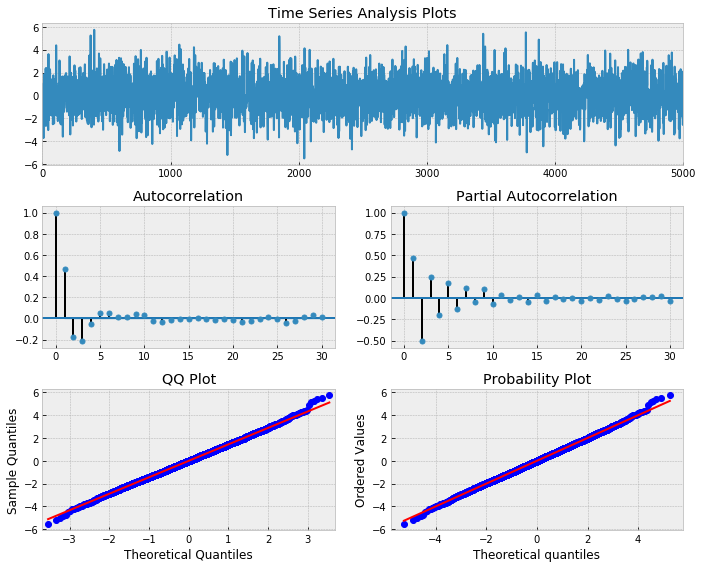

In [31]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

Test which model fits the best:  which model produces the lowest Akaike Information Criterion (AIC).

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14250.83208 | order: (4, 2)


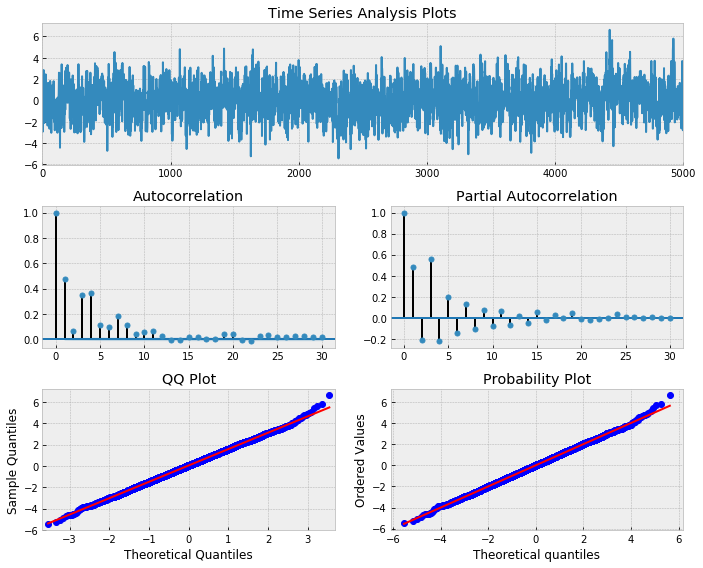

In [32]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

Fit an ARMA model to SPY returns:

- The ACF and PACF are showing no significant autocorrelation. 
- The QQ and Probability Plots show the residuals are approximately normal with heavy tails. 
- However, this model's residuals do NOT look like white noise! Look at the highlighted areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured. 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -11518.64632 | order: (4, 3)


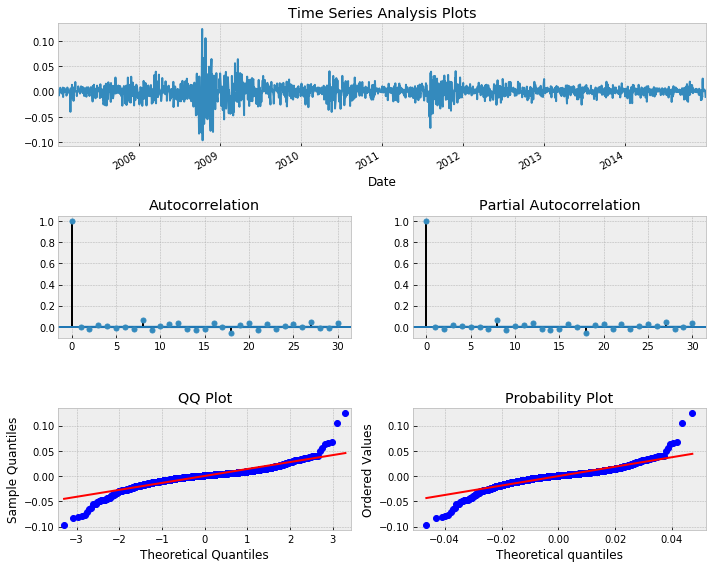

In [35]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
_ = tsplot(best_mdl.resid, lags=max_lag)

ARIMA(p,d,q):  the "d" references the number of times we are differencing the series

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

aic: -11518.64632 | order: (4, 0, 3)


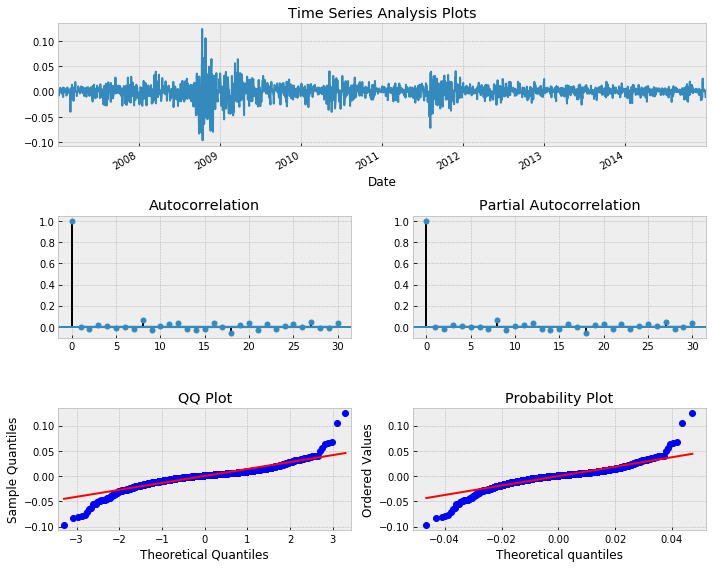

In [100]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [53]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001121,-0.025901,-0.034391,0.028143,0.036634
2015-01-01,-0.000200,-0.027334,-0.035860,0.026934,0.035461
2015-01-02,0.000063,-0.027105,-0.035642,0.027231,0.035768
2015-01-03,0.000617,-0.026551,-0.035088,0.027786,0.036323
2015-01-04,-0.000173,-0.027345,-0.035883,0.026999,0.035537


The in-sample prediction is really disappointing...Judging from above, I think the model failed to calibrate...

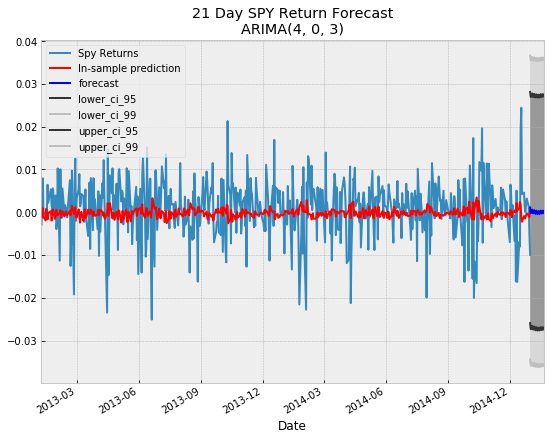

In [101]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

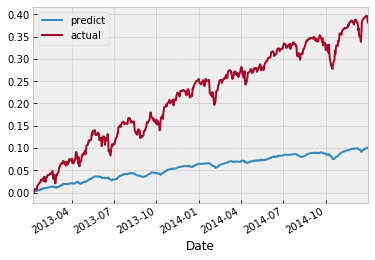

In [125]:
pd.DataFrame([(-pred.cumsum()), ts.cumsum()],index = ["predict", "actual"]).transpose().plot()

Looks like prediction should be scaled by its vol?

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


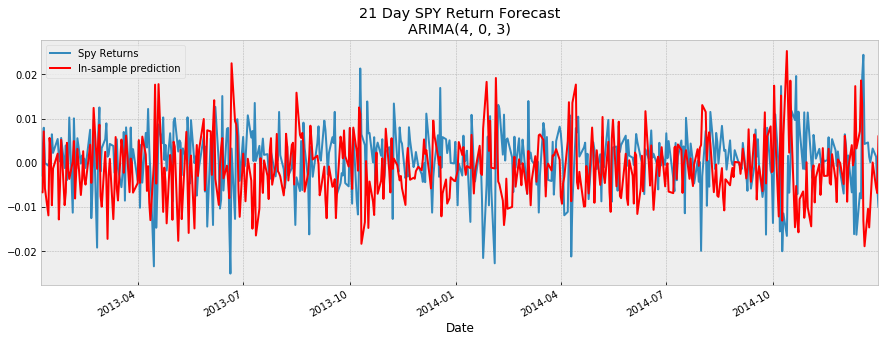

In [155]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
calib_ts = lrets.SPY.copy()
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred =  smt.ARIMA(calib_ts, order=(4,0,4)).fit(method='mle', trend='nc').predict(ts.index[0], ts.index[-1])
pred = pred*ts.std()/pred.std() #why do we need to normalize??

pred.plot(ax=ax, style='r-', label='In-sample prediction', figsize = (15,5))
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

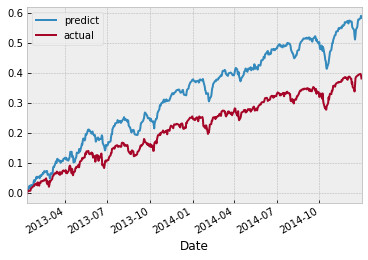

In [152]:
pd.DataFrame([(-pred.cumsum()), ts.cumsum()],index = ["predict", "actual"]).transpose().plot()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


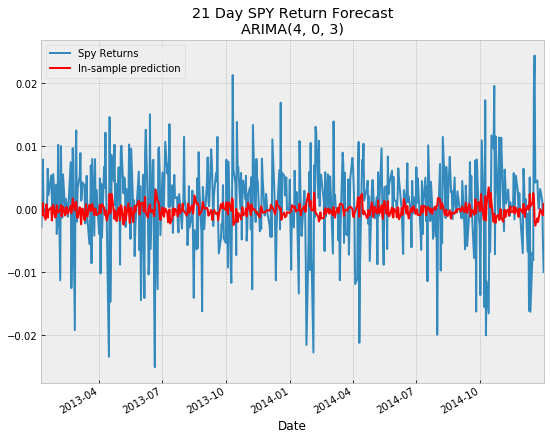

In [146]:
# firstly normalized ts std

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
calib_ts = lrets.SPY.copy()
#need to create and predict together, otherwise cached...super dangerous
pred = smt.ARIMA(calib_ts, order=(4,0,4)).fit(method='mle', trend='nc').predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

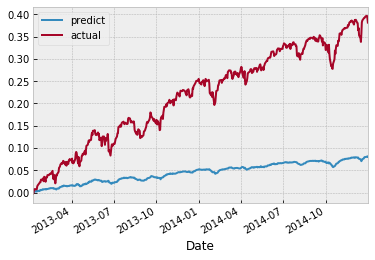

In [147]:
pd.DataFrame([(-pred.cumsum()), ts.cumsum()],index = ["predict", "actual"]).transpose().plot()

ARCH(p):

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series. Another way to think about it, is that the variance of our time series NOW at time t, is conditional on past observations of the variance in previous periods.

Assuming the series has zero mean we can express the model AR(1) as:

$
y_t= \sigma_t \epsilon_t\\
\epsilon_t\sim N(0,1)\\
\sigma_t^2 = a_0 + a_1y_{t-1}^2$


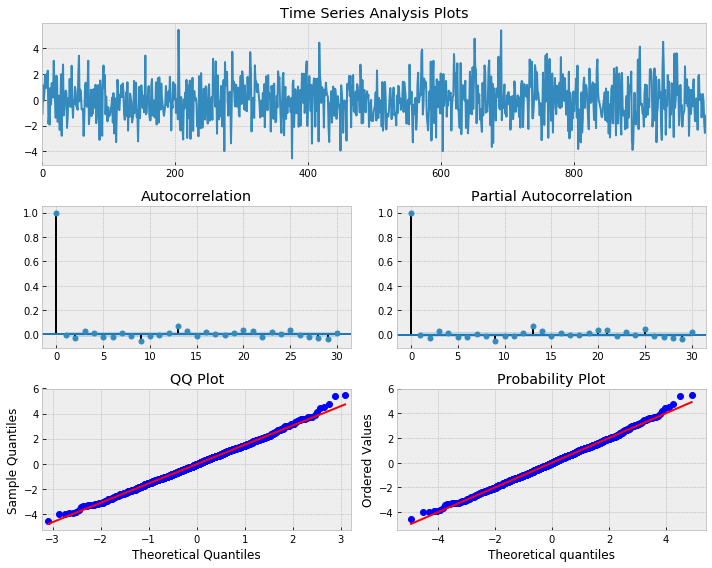

In [5]:
np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

$ARCH(1)^2$:

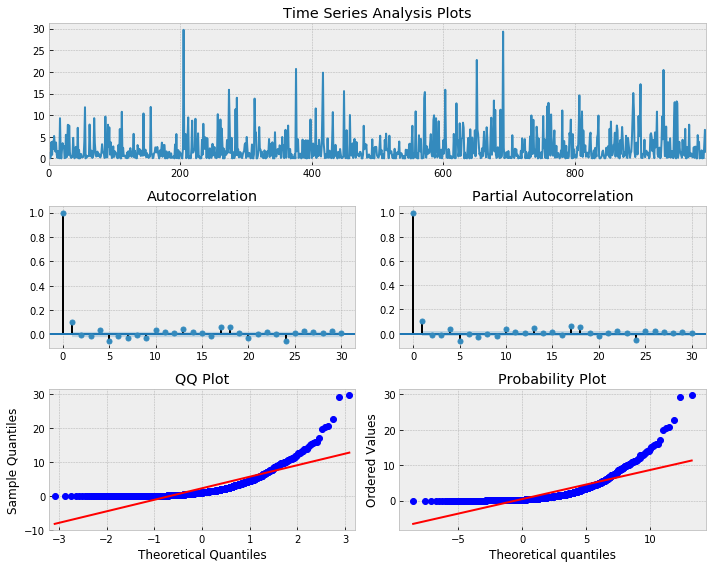

In [9]:
tsplot(np.power(Y,2), lags=30)

GARCH(p,q): 

Simply put GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process. The basic GARCH(1, 1) formula is:

$
y_t= \sigma_t \epsilon_t\\
\epsilon_t\sim N(0,1)\\
\sigma_t^2 = a_0 + a_1\epsilon_{t-1}^2+ b_1\sigma_{t-1}^2$

Stability requirement:
$a_1+b_1<1$

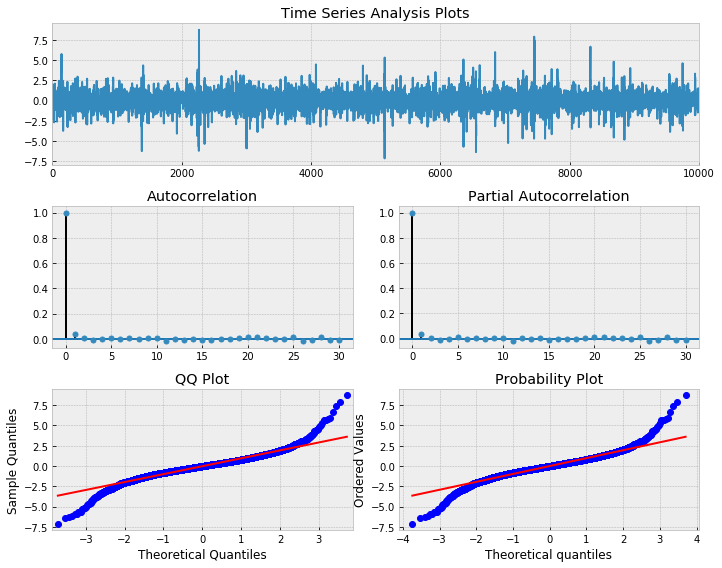

In [10]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

Compared with white noise, the squared GARCH(1,1) has non-zero autocorrelation and partial autocorrelation.

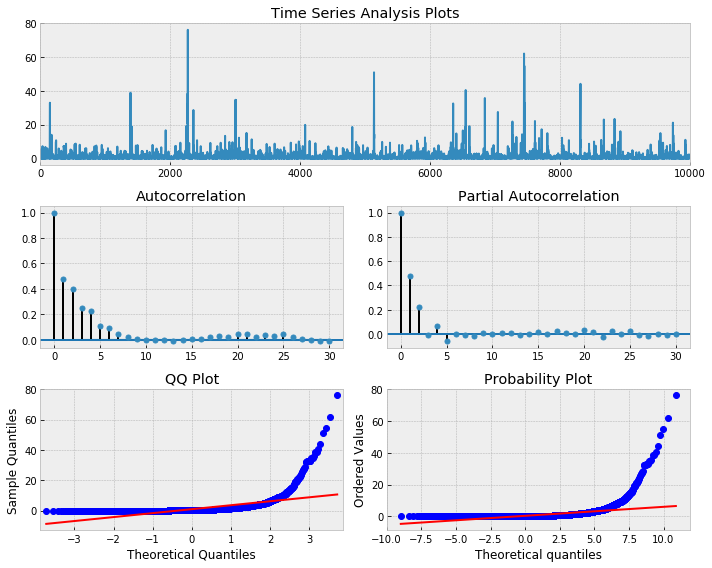

In [11]:
_ = tsplot(np.power(eps,2), lags=30)

In [15]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sun, Jan 14 2018   Df Residuals:                     9996
Time:      

In [17]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3

aic: -5255.56848 | order: (3, 0, 2)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


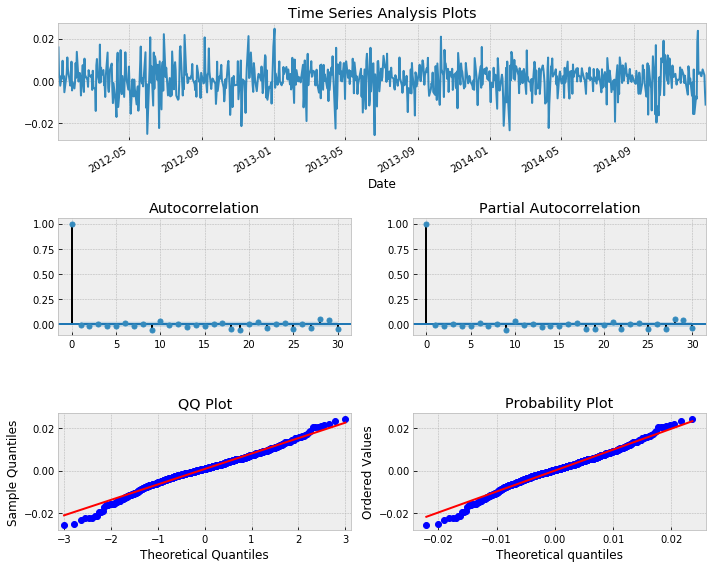

In [22]:
_ = tsplot(res_tup[2].resid, lags=30)

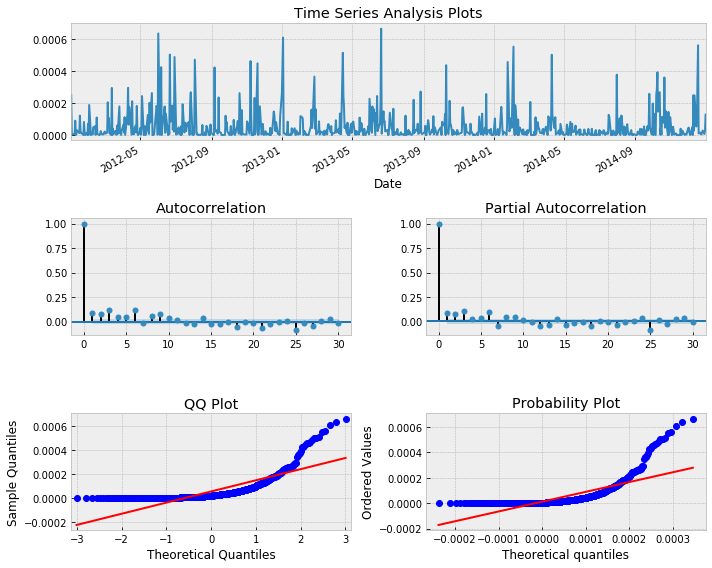

In [23]:
_ = tsplot(np.power(res_tup[2].resid,2), lags=30)

In [26]:
# Now we can fit the arch model using the best fit arima model parameters
order = res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                      -9.583
Mean Model:                   Constant Mean   Adj. R-squared:                 -9.583
Vol Model:                            GARCH   Log-Likelihood:                1695.50
Distribution:      Standardized Student's t   AIC:                          -3374.99
Method:                  Maximum Likelihood   BIC:                          -3337.99
                                              No. Observations:                  754
Date:                      Sun, Jan 14 2018   Df Residuals:                      746
Time:                              12:16:31   Df Model:                            8
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


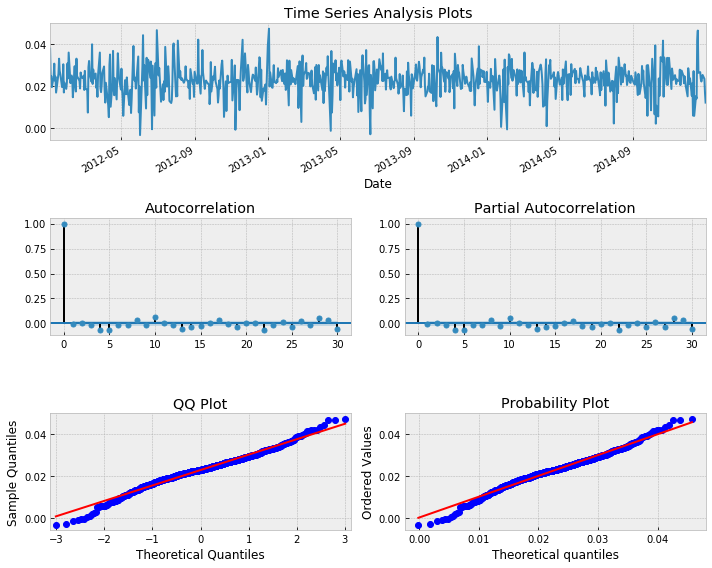

In [28]:
_ = tsplot(np.power(res.resid,1), lags=30)

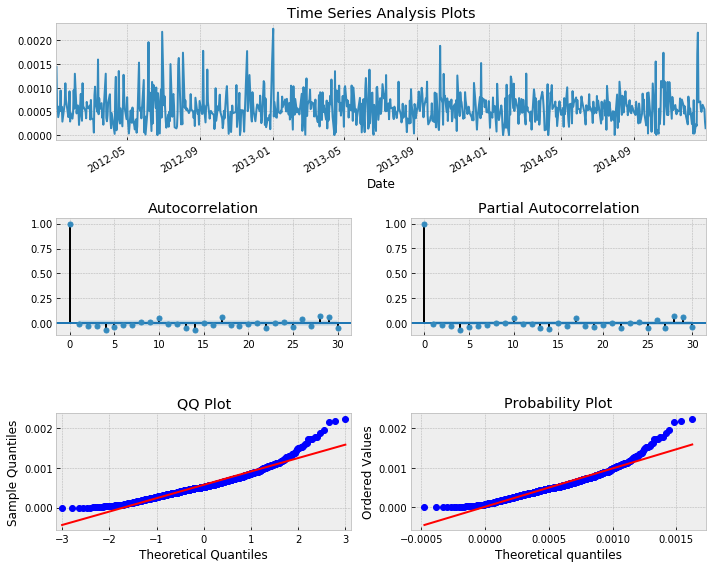

In [27]:
_ = tsplot(np.power(res.resid,2), lags=30)

In [32]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001585,-0.012835,-0.017366,0.016004,0.020535
2015-01-01,0.000976,-0.013444,-0.017975,0.015396,0.019927
2015-01-02,0.000443,-0.013979,-0.018511,0.014866,0.019398
2015-01-03,-0.000289,-0.014713,-0.019245,0.014134,0.018666
2015-01-04,-0.000833,-0.015264,-0.019799,0.013597,0.018132


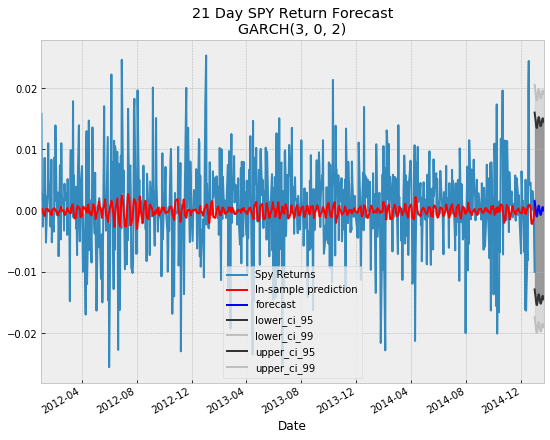

In [34]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

# ts = lrets.SPY.iloc[-500:].copy()
ts = TS
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
best_mdl = res_tup[2];
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nGARCH{}'.format(n_steps, order))
plt.legend(loc='best', fontsize=10)

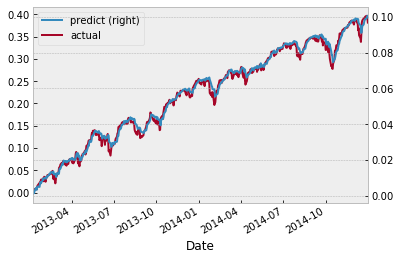

In [59]:
pd.DataFrame([(-pred.cumsum()), ts.cumsum()],index = ["predict", "actual"]).transpose().plot(secondary_y=["predict"])